Implementation of SARSA and SARSAMAX with markdown. Note this markdown is provided as a follow along to the code, it is not an in depth analysis of the algorithms, rather it is a breakdown of each function and the logic of each function.

Kindly refer to the documentation for an in depth analysis.

In [1]:
import numpy as np
import random as ran
import math

# for displaying images not necessary for function
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import necessary packages

In [2]:
def total(cards):
    sum_cards = 0
    A_s = 0
    AceFlags = False

    for card in cards:
        if card == 'J' or card == 'Q' or card == 'K':
            sum_cards += 10
        elif card == 'A':
            A_s += 1
            sum_cards += 1
        else:
            sum_cards += card

    for x in range(A_s):
        if (sum_cards+10) <= 21:
            sum_cards += 10
            AceFlags = True

    return sum_cards, AceFlags

This function returns the sum of a players cards given their hand and a flag which shows that the player has an ace.

The summing process is simple and straight foward simply adding the values of the cards. Replacing the royal cards for 10, with exception to how the ace is handled.

Ace's are initially added to the sum as 1, after the summing process if the total allows for an Ace to be used as an 11 it is changed to 11 and a flag (boolean) denotes the usage of an ace.

In [3]:
def playerPolicy(playerHand, d):
    while True:
        if total(playerHand)[0] < 12: #Player policy, hit if less than 12
            playerHand.append(d.pop(ran.randint(0, len(d) - 1)))
        else:
            return playerHand, d

This function defines the policy of the player. If the total in the players hand is less than 12 he automatically hits.

In BlackJack it is impossible to go over if a players total is less than 12.

In [4]:
def takeActionEpsilon(Q, epsilon, myState, allActions):
    action = 0  # stand by default

    if np.random.random() >= epsilon:
        value = -9999
        for act in Q[myState]:
            if Q[myState][act] > value:
                action = act
                value = Q[myState][act]
    else:
        action = np.random.choice(allActions)

    return action

Function returns the action that the player should persue. Initially he is set to stand. If a value is greater than epsilon it persues an action based on the Q table. otherwise it makes a random choice. Hence if the epsilon is set to 1 the player wilkl always persue randome choices.

In [5]:
def takeGreedyAction(Q, myState):
    action = 0  # stand by default

    value = -9999
    for act in Q[myState]:
        if Q[myState][act] > value:
            action = act
            value = Q[myState][act]

    return action

Similar to the function above except it always uses the Qtable an not a random choice.

In [6]:
def enviorment():

    deck = ['A', 'A', 'A', 'A', 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9,
            9, 9, 9, 10, 10, 10, 10, 'J', 'J', 'J', 'J', 'Q', 'Q', 'Q', 'Q', 'K', 'K', 'K', 'K']

    dealer = list()
    player = list()

    player.append(deck.pop(ran.randint(0, len(deck) - 1)))  # Draw twice for player
    player.append(deck.pop(ran.randint(0, len(deck) - 1)))
    dealer.append(deck.pop(ran.randint(0, len(deck) - 1)))  # Draw once for dealer

    return player, dealer, deck

The Game environmen. A deck of cards is initilised along with the player and dealer hands. It begins by drawing twice for the player and once for the dealer.

In [7]:
def IniQ():
    actions = [1, 0]
    QTable = {}
    learningRate = 1
    maxSteps = 2500

    for playerHand in range(12, 21):  # Player sum [12..20]
        for dealerHand in range(2, 12):  # Card dealer [2..11]
            for ace in [1, 0]:  # Has card / Doesn't
                QTable[(playerHand, dealerHand, ace)] = {}
                for action in actions:  # Initilise value to 0
                    QTable[(playerHand, dealerHand, ace)][action] = 0 #Set all values to 0

    return actions, QTable, learningRate, maxSteps

Function initilises QTable. The player has two possible actions hit or stand. The for loop (range(12,21)) represents all the possible states of the player, because the player automatically hits before a sum of 12 and stands if greater than 20.

The Dealer starts with one card and this card can only have a value between 2 and 11 (both included).

The Player may also have an ace (1) or doesn't (0). This flag is used to determine if the player has an ace which he can make use of.

In [8]:
def takeStep(action, deck, player, dealerHand):

    if action == 1:  # Hit
        player.append(deck.pop(ran.randint(0, len(deck) - 1)))

        if total(player)[0] > 21:  # Stand if player greater to 21
            reward = -1.0
            done = True
            wld = -1
        elif total(player)[0] == 21:  # Stand if player greater to 21
            done = True
            while total(dealerHand)[0] < 17:  # Dealer policy, hit less than 17
                dealerHand.append(deck.pop(ran.randint(0, len(deck) - 1)))  # stand otherwise

            if total(dealerHand)[0] > 21:  # Player wins
                reward = +1.0
                wld = 1

            elif total(dealerHand)[0] == total(player)[0]:  # Dealer wins
                reward = 0.0
                wld = 0
            else:
                reward = +1.0
                wld = 1

        else:
            done = False
            reward = 0.0
            wld = 0
    else:
        done = True

        while total(dealerHand)[0] < 17:  # Dealer policy, hit less than 17
            dealerHand.append(deck.pop(ran.randint(0, len(deck) - 1)))  # stand otherwise
        if total(dealerHand)[0] > 21: #Player wins
            reward = +1.0
            wld = 1

        elif total(dealerHand)[0] > total(player)[0]: #Dealer wins
            reward = -1.0
            wld = -1
        elif total(player)[0] > total(dealerHand)[0]: #Player wins
            reward = +1.0
            wld = 1
        else: #Draw
            reward = 0.0
            wld = 0

    return reward, done, deck, wld

The step function determines the players next move and the reward the be given to the player at the end with the following values.

Reward of 1 Win
Reward of 0 Draw
Reward of -1 Loss

The player makes the initial choice of either hitting or standing. Hitting results in 3 possible actions. If the player draws a hand greater than 21, he automatically loses and the game ends there with a negative reward. If the hand is equal to 21, the player stands and the dealer starts playing. Otherwise the player continues playing (taking steps).

If the player chooses the stand the dealer starts playing. The dealer continues to hit until he has a total greater or equal to 17. If the dealer goes over the player wins. If the dealer has a greater hand than the player, the player loses. If the player has the greater hand they win, otherwise their hand are equal and they draw.

In [9]:
def Train(Sarsa, config, episodes=500000):
    episodes_plot = []
    wins_plot = []
    losses_plot = []
    draws_plot = []
    acts, Qt, lr, maxSteps = IniQ()
    QtCounter = IniQ() [1]
    win, lose, draw, unqiueStateAction, rewardTotal = 0, 0, 0, 0, 0
    winlosedraw = 0
    for episode in range(episodes):
        if episode % 1000 == 0:
            episodes_plot.append(episode)
            print("Win {} | Lose {} | Draw {}".format(win,lose,draw))
            wins_plot.append(win)
            losses_plot.append(lose)
            draws_plot.append(draw)
            print("Reward {}".format(rewardTotal))
            win, lose, draw, rewardTotal = 0, 0, 0, 0

            print("Round", episode)
        config = int(config)
        if config == 1:
            ep = 0.1
        elif config == 2:
            ep = math.exp(-episode/1000)
        elif config == 3:
            ep = math.exp(-episode/10000)
        else:
            ep = 1/(episode+1)
        iniPlayerState, iniDealerState, MainDeck = enviorment()  # Initilise the enviroment
        PlayerState, MainDeck = playerPolicy(iniPlayerState, MainDeck)
        currentAction = 1
        s_next = None
        a_next = None
        t = 0
        if total(PlayerState)[0] > 21:  # Stand if player greater or equal to 21
            lose += 1
            continue
        if total(PlayerState)[0] == 21:
            win += 1
            continue
        
        ace11 = total(PlayerState)[1]
        
        s = (total(PlayerState)[0], total(iniDealerState)[0], ace11)
        a = takeActionEpsilon(Qt, ep, s, acts)  # Choose an action
        QtCounter[s][a] +=1
        
        while t < maxSteps and currentAction == 1:  # While hitting: #no steps
            t += 1

            IntermidiateReward, done, MainDeck, winlosedraw = takeStep(a, MainDeck, PlayerState, iniDealerState)
            rewardTotal = rewardTotal + IntermidiateReward

            if not done:
                s_next = (total(PlayerState)[0], total(iniDealerState)[0], ace11)
                if Sarsa:
                    a_next = takeActionEpsilon(Qt, ep, s_next, acts)
                else:
                    a_next = takeGreedyAction(Qt, s_next)
                QtCounter[s_next][a_next] = QtCounter[s_next][a_next] + 1

            if done:
                Qt[s][a] += 0.3 * (IntermidiateReward - Qt[s][a])
            else:
                Qt[s][a] += 0.3 * (IntermidiateReward + (lr * Qt[s_next][a_next]) - Qt[s][a])

            s, a = s_next, a_next

            if done:
                break

        if(winlosedraw==1):
            win += 1
        elif(winlosedraw == -1):
            lose += 1
        else:
            draw += 1


    print("Finished Training!")

    return Qt, episodes_plot, wins_plot, losses_plot, draws_plot , QtCounter

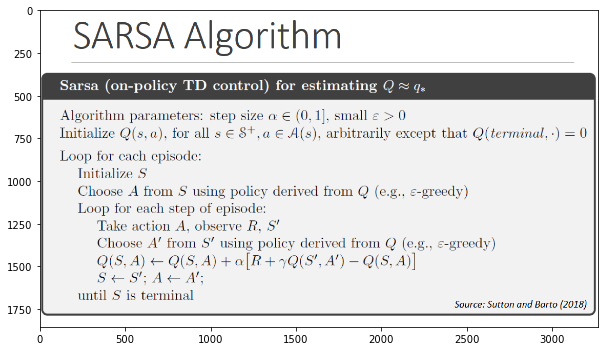

In [10]:
img = plt.imread("Images/SARSA_Algo.png")
plt.rcParams["figure.figsize"] = (10,6)
plt.imshow(img, interpolation='nearest')
plt.show()

This function mirrors the Algorithn shown above. Starting by initilising the Q-table with the iniQ function. Then looping for the specified amount of episodes. The training function is set to loop for 500,000 episodes, with the win/loss being outputted every 1,000 episodes.

It initilises S and chooses A from the takeActionEpsilon function.

The stepping loop represents the player taking and action. After every iteration the user makes the choice to hit or stand (returned from the takeStep function). When the player "is done" (stands), the stepping loop is exited. There also is a MaxSteps parameter but this is mainly used for larger environments (example pacman). In BlackJack, the maximum amount of hits a player can achieve before busting is 9, this parameter was more to show an understanding of the algorithm.

A' is determined differently depending if the user chose SARSA or SARSAMAX.

The Function returns the Q-Table upon completion.

In [11]:
SarsaFlag = False
val = input("Configure AI to work with SARSA (1), SARSAMAX is configured by default\n")
if int(val) == 1:
    SarsaFlag = True #Sarsa

conf = input("Configure AI to work with (1) e = 0.1, (2) e = 1/k', (3) e^-k/1000, (4) e^-k/10000\n")
Q, episodes_line_plot, wins_line_plot, losses_line_plot, draw_line_plot , SACounter = Train(SarsaFlag, conf)

print("(PlayerHand, DealerHand, Ace), {Action values}")
for k, v in Q.items():
    print(k,v)

Configure AI to work with SARSA (1), SARSAMAX is configured by default
2
Configure AI to work with (1) e = 0.1, (2) e = 1/k', (3) e^-k/1000, (4) e^-k/10000
4
Win 0 | Lose 0 | Draw 0
Reward 0
Round 0
Win 391 | Lose 557 | Draw 52
Reward -244.0
Round 1000
Win 427 | Lose 502 | Draw 71
Reward -152.0
Round 2000
Win 392 | Lose 526 | Draw 82
Reward -201.0
Round 3000
Win 428 | Lose 509 | Draw 63
Reward -156.0
Round 4000
Win 404 | Lose 507 | Draw 89
Reward -176.0
Round 5000
Win 426 | Lose 490 | Draw 84
Reward -135.0
Round 6000
Win 420 | Lose 499 | Draw 81
Reward -158.0
Round 7000
Win 432 | Lose 491 | Draw 77
Reward -126.0
Round 8000
Win 412 | Lose 500 | Draw 88
Reward -160.0
Round 9000
Win 415 | Lose 502 | Draw 83
Reward -150.0
Round 10000
Win 421 | Lose 515 | Draw 64
Reward -166.0
Round 11000
Win 433 | Lose 480 | Draw 87
Reward -114.0
Round 12000
Win 422 | Lose 481 | Draw 97
Reward -122.0
Round 13000
Win 407 | Lose 519 | Draw 74
Reward -174.0
Round 14000
Win 410 | Lose 516 | Draw 74
Reward -180

Win 408 | Lose 492 | Draw 100
Reward -146.0
Round 160000
Win 418 | Lose 490 | Draw 92
Reward -142.0
Round 161000
Win 382 | Lose 536 | Draw 82
Reward -219.0
Round 162000
Win 422 | Lose 511 | Draw 67
Reward -173.0
Round 163000
Win 417 | Lose 496 | Draw 87
Reward -149.0
Round 164000
Win 419 | Lose 506 | Draw 75
Reward -161.0
Round 165000
Win 409 | Lose 496 | Draw 95
Reward -150.0
Round 166000
Win 419 | Lose 481 | Draw 100
Reward -126.0
Round 167000
Win 442 | Lose 472 | Draw 86
Reward -110.0
Round 168000
Win 433 | Lose 486 | Draw 81
Reward -123.0
Round 169000
Win 446 | Lose 458 | Draw 96
Reward -92.0
Round 170000
Win 423 | Lose 493 | Draw 84
Reward -144.0
Round 171000
Win 431 | Lose 481 | Draw 88
Reward -129.0
Round 172000
Win 404 | Lose 494 | Draw 102
Reward -148.0
Round 173000
Win 401 | Lose 521 | Draw 78
Reward -189.0
Round 174000
Win 427 | Lose 502 | Draw 71
Reward -158.0
Round 175000
Win 421 | Lose 486 | Draw 93
Reward -144.0
Round 176000
Win 416 | Lose 491 | Draw 93
Reward -130.0
Rou

Win 409 | Lose 501 | Draw 90
Reward -164.0
Round 308000
Win 434 | Lose 481 | Draw 85
Reward -120.0
Round 309000
Win 438 | Lose 482 | Draw 80
Reward -114.0
Round 310000
Win 446 | Lose 477 | Draw 77
Reward -95.0
Round 311000
Win 447 | Lose 477 | Draw 76
Reward -102.0
Round 312000
Win 436 | Lose 488 | Draw 76
Reward -112.0
Round 313000
Win 417 | Lose 492 | Draw 91
Reward -138.0
Round 314000
Win 431 | Lose 497 | Draw 72
Reward -126.0
Round 315000
Win 425 | Lose 489 | Draw 86
Reward -123.0
Round 316000
Win 449 | Lose 472 | Draw 79
Reward -108.0
Round 317000
Win 440 | Lose 483 | Draw 77
Reward -118.0
Round 318000
Win 399 | Lose 521 | Draw 80
Reward -185.0
Round 319000
Win 427 | Lose 487 | Draw 86
Reward -123.0
Round 320000
Win 419 | Lose 482 | Draw 99
Reward -143.0
Round 321000
Win 435 | Lose 473 | Draw 92
Reward -121.0
Round 322000
Win 414 | Lose 492 | Draw 94
Reward -153.0
Round 323000
Win 432 | Lose 479 | Draw 89
Reward -98.0
Round 324000
Win 424 | Lose 486 | Draw 90
Reward -146.0
Round 3

Win 450 | Lose 469 | Draw 81
Reward -95.0
Round 471000
Win 422 | Lose 499 | Draw 79
Reward -144.0
Round 472000
Win 420 | Lose 497 | Draw 83
Reward -142.0
Round 473000
Win 422 | Lose 507 | Draw 71
Reward -150.0
Round 474000
Win 406 | Lose 513 | Draw 81
Reward -160.0
Round 475000
Win 409 | Lose 492 | Draw 99
Reward -143.0
Round 476000
Win 413 | Lose 511 | Draw 76
Reward -154.0
Round 477000
Win 411 | Lose 496 | Draw 93
Reward -153.0
Round 478000
Win 417 | Lose 495 | Draw 88
Reward -159.0
Round 479000
Win 408 | Lose 495 | Draw 97
Reward -151.0
Round 480000
Win 424 | Lose 497 | Draw 79
Reward -152.0
Round 481000
Win 417 | Lose 499 | Draw 84
Reward -162.0
Round 482000
Win 449 | Lose 456 | Draw 95
Reward -70.0
Round 483000
Win 433 | Lose 491 | Draw 76
Reward -123.0
Round 484000
Win 427 | Lose 475 | Draw 98
Reward -112.0
Round 485000
Win 433 | Lose 490 | Draw 77
Reward -122.0
Round 486000
Win 404 | Lose 510 | Draw 86
Reward -190.0
Round 487000
Win 409 | Lose 511 | Draw 80
Reward -177.0
Round 4

In [12]:
import numpy as np
import pandas as pd
my_array = np.zeros((9, 10) , dtype=str)          

df = pd.DataFrame(my_array, columns = ['2','3','4','5','6','7','8','9','10','A'])
df.index += 12

my_array2 = np.zeros((9, 10) , dtype=str)          

df2 = pd.DataFrame(my_array, columns = ['2','3','4','5','6','7','8','9','10','A'])
df2.index += 12

for k, v in Q.items():
    if k[2] == 0:
        x = k[0]-12
        y = k[1]-2
        if v[0] > v[1]:
            df.values[x,y] = 'S'
        else:
            df.values[x,y] = 'H'         
    elif k[2] == 1:
        x = k[0]-12
        y = k[1]-2
        if v[0] > v[1]:
            df2.values[x,y] = 'S'
        else:
            df2.values[x,y] = 'H'
            
df = df.sort_index(ascending=False)
df2 = df2.sort_index(ascending=False)

In [13]:
df.style.set_table_attributes("style='display:inline'").set_caption('Player is using an Ace as 1')

,2,3,4,5,6,7,8,9,10,A
20,S,S,S,S,S,S,S,S,S,S
19,S,S,S,S,S,S,S,S,S,S
18,S,S,S,S,S,S,S,S,S,S
17,S,S,S,S,S,S,H,S,S,H
16,S,S,S,H,S,H,H,H,H,H
15,H,S,H,S,H,H,H,H,H,H
14,H,H,H,S,S,H,H,H,H,H
13,H,H,H,H,H,H,H,H,H,H
12,H,H,H,S,H,H,H,H,H,H


In [14]:
df2.style.set_table_attributes("style='display:inline'").set_caption('Player is using an Ace as 11')

,2,3,4,5,6,7,8,9,10,A
20,S,S,S,S,S,S,S,S,S,S
19,S,S,S,S,S,S,S,S,S,H
18,S,H,S,S,S,S,S,S,H,H
17,H,H,H,S,H,H,H,H,H,H
16,H,H,H,H,S,H,H,H,H,H
15,H,H,H,H,S,H,H,H,H,H
14,H,S,H,H,S,H,H,H,H,H
13,H,H,H,H,H,H,H,H,H,H
12,H,H,H,H,H,H,H,H,H,H


The user chooses weather to use SARSA or SARSAMAX, then they chooses the epsilon greedy policy.

The relative functions are called.

The program finishes by outputting the final Q table.

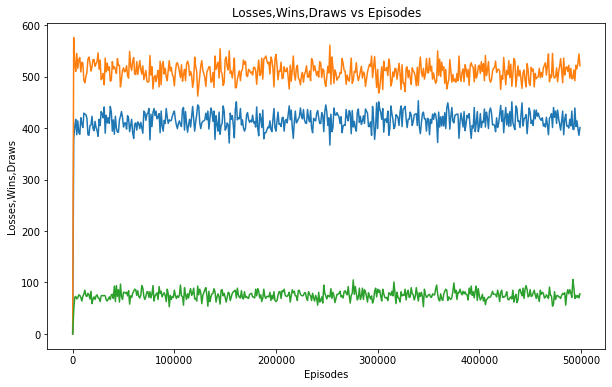

In [55]:
plt.plot(episodes_line_plot, wins_line_plot)
plt.plot(episodes_line_plot, losses_line_plot)
plt.plot(episodes_line_plot, draw_line_plot)
plt.title('Losses,Wins,Draws vs Episodes')
plt.xlabel('Episodes')
plt.ylabel('Losses,Wins,Draws')
plt.show()

Losses,Wins,Draws vs Episodes with Losses in Orange, Wins in Blue and Draws in Green.

The results of this graph will be used in the Evaluation.

['(20, 10, 0) Stand', '(19, 10, 0) Stand', '(12, 10, 0) Hit', '(13, 10, 0) Hit', '(18, 10, 0) Stand', '(15, 10, 0) Hit', '(14, 10, 0) Hit', '(16, 10, 0) Hit', '(17, 10, 0) Stand', '(17, 10, 0) Hit', '(20, 11, 0) Stand', '(20, 9, 0) Stand', '(20, 7, 0) Stand', '(20, 8, 0) Stand', '(16, 10, 0) Stand', '(20, 2, 0) Stand', '(20, 4, 0) Stand', '(20, 6, 0) Stand', '(20, 5, 0) Stand', '(20, 3, 0) Stand', '(15, 10, 0) Stand', '(19, 11, 0) Stand', '(20, 10, 1) Stand', '(19, 8, 0) Stand', '(15, 11, 0) Hit', '(13, 11, 0) Hit', '(18, 11, 0) Stand', '(14, 11, 0) Hit', '(18, 7, 0) Stand', '(19, 7, 0) Stand', '(16, 11, 0) Hit', '(12, 11, 0) Hit', '(14, 10, 0) Stand', '(13, 9, 0) Hit', '(12, 9, 0) Hit', '(19, 9, 0) Stand', '(12, 7, 0) Hit', '(18, 9, 0) Stand', '(12, 8, 0) Hit', '(17, 6, 0) Stand', '(17, 7, 0) Stand', '(17, 10, 1) Hit', '(13, 7, 0) Hit', '(18, 8, 0) Stand', '(17, 3, 0) Stand', '(16, 10, 1) Hit', '(18, 2, 0) Stand', '(18, 3, 0) Stand', '(14, 8, 0) Hit', '(19, 2, 0) Stand', '(18, 4, 0) S

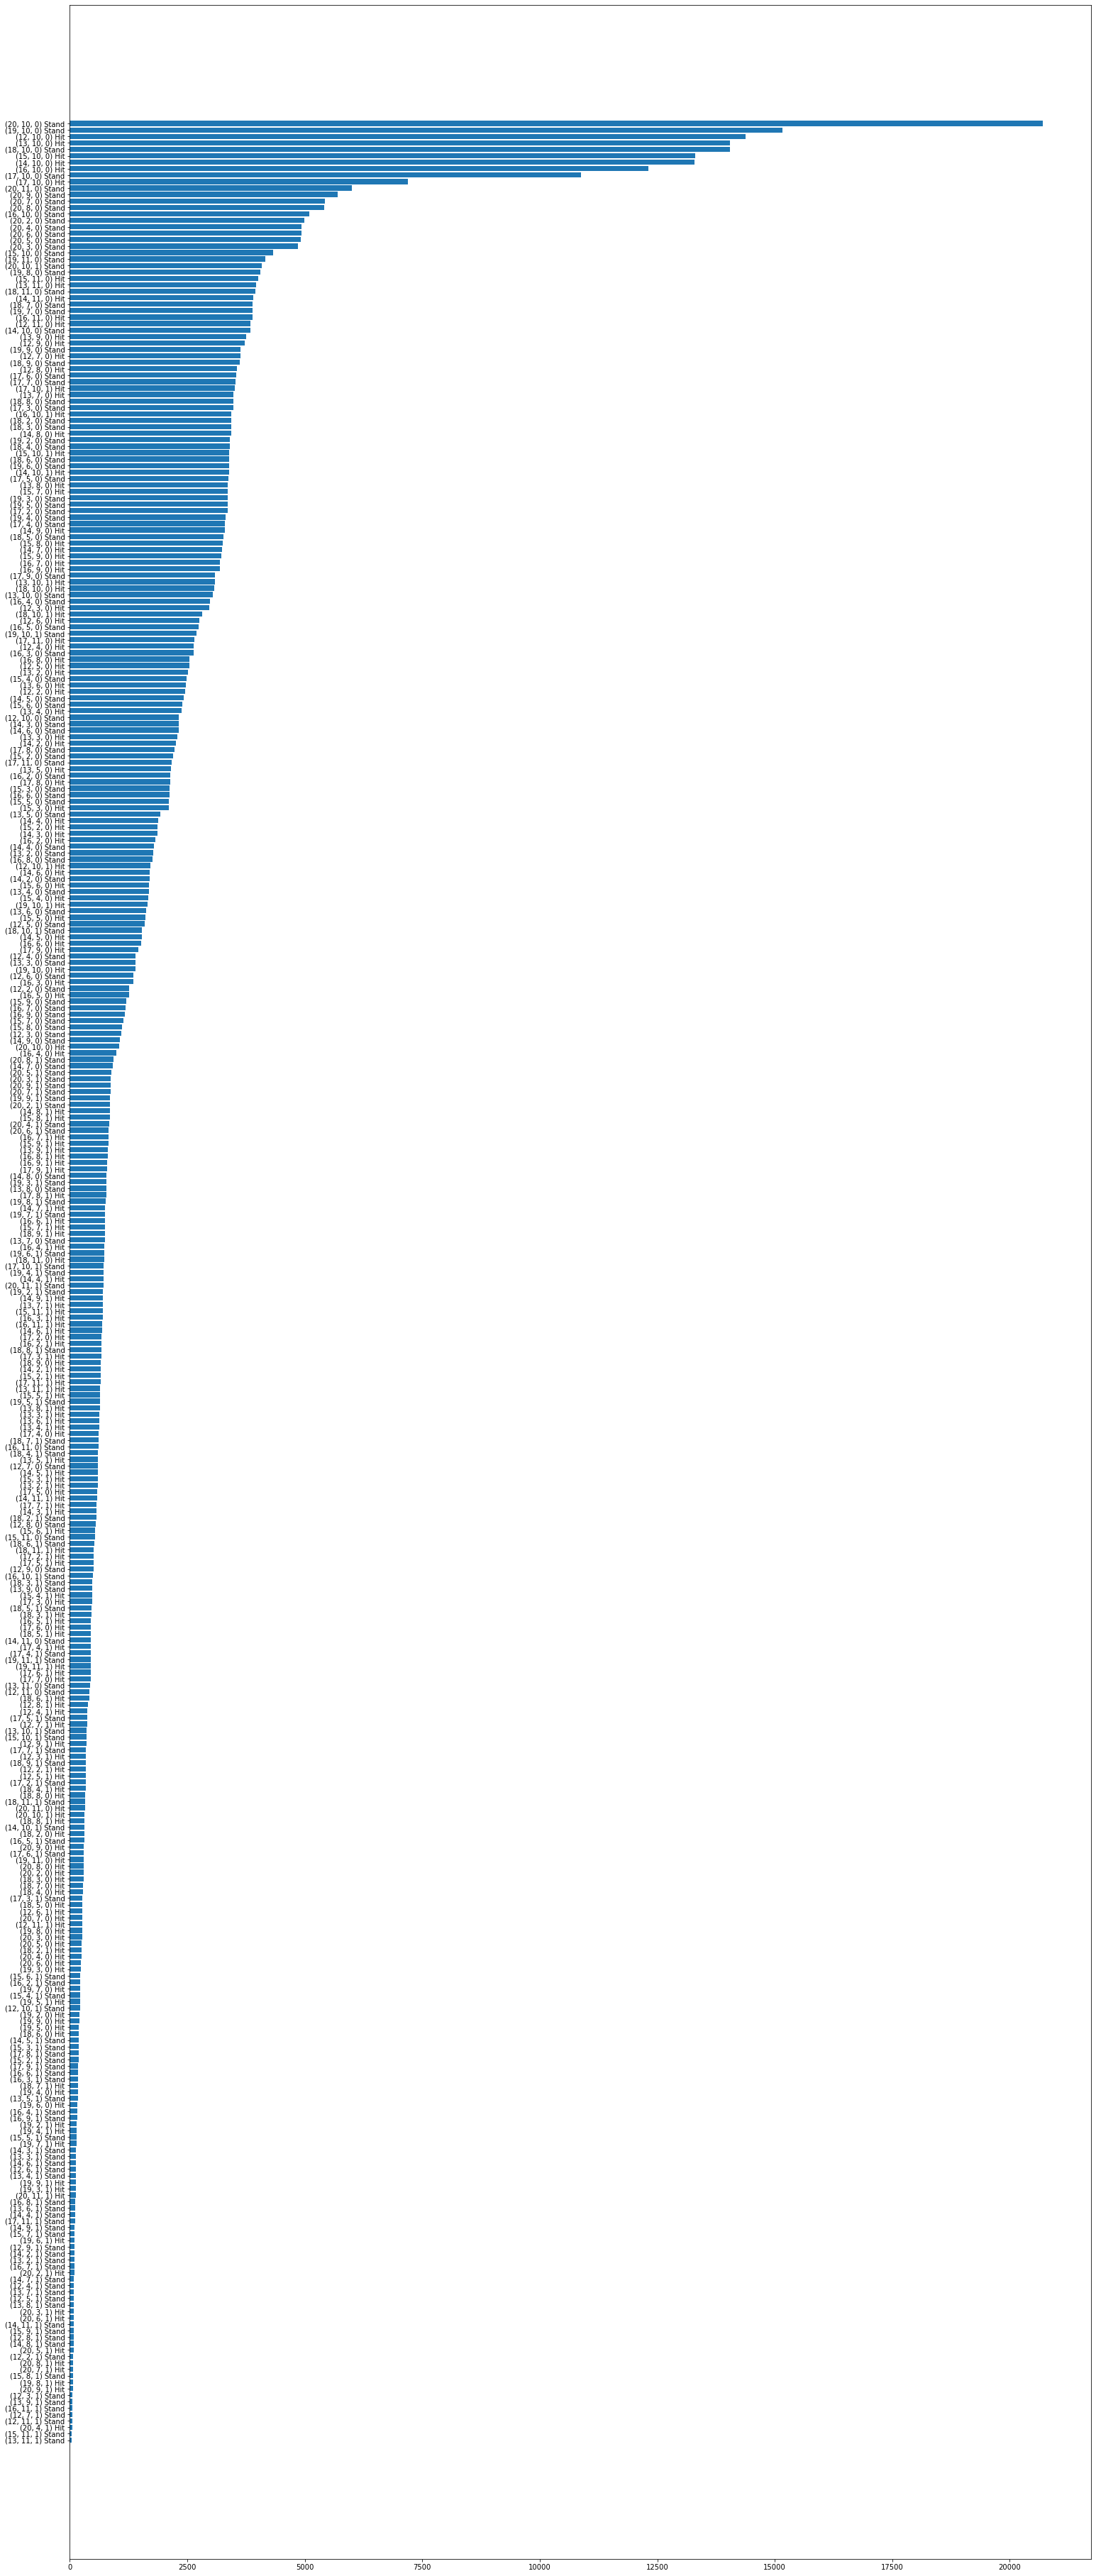

In [56]:
states = list()
action = list()
for k,v in SACounter.items():
    states.append(k)
    states.append(k)
    action.append(v[0])
    action.append(v[1])
for names in range(len(states)):
    if names % 2 == 0:
        states[names] = str(states[names]) + ' Stand'
    else: 
        states[names] = str(states[names]) + ' Hit'
length = len(states)
statesNew = list()
actionNew = list()
for x in range(length):
    indexpop = action.index(max(action))
    statesNew.append(states.pop(indexpop))
    actionNew.append(action.pop(indexpop))
fig = figure(figsize=(20,50))
print(statesNew)
print(actionNew)
statesNew.reverse()
actionNew.reverse()
print(len(actionNew))
ax = fig.add_axes([0,0,1,1])
# ax2 = fig.add_axes([0,0,1,1])
ax.barh(statesNew, actionNew)
# ax2.barh(statesNew[length//6:], actionNew[length//6:])
plt.show()

Win 0 | Lose 0 | Draw 0
Reward 0
Round 0
Win 389 | Lose 546 | Draw 65
Reward -222.0
Round 1000
Win 417 | Lose 510 | Draw 73
Reward -173.0
Round 2000
Win 420 | Lose 502 | Draw 78
Reward -160.0
Round 3000
Win 404 | Lose 504 | Draw 92
Reward -168.0
Round 4000
Win 424 | Lose 494 | Draw 82
Reward -153.0
Round 5000
Win 413 | Lose 514 | Draw 73
Reward -170.0
Round 6000
Win 389 | Lose 544 | Draw 67
Reward -219.0
Round 7000
Win 418 | Lose 513 | Draw 69
Reward -175.0
Round 8000
Win 422 | Lose 507 | Draw 71
Reward -155.0
Round 9000
Win 429 | Lose 491 | Draw 80
Reward -130.0
Round 10000
Win 418 | Lose 508 | Draw 74
Reward -158.0
Round 11000
Win 438 | Lose 488 | Draw 74
Reward -115.0
Round 12000
Win 446 | Lose 480 | Draw 74
Reward -108.0
Round 13000
Win 426 | Lose 504 | Draw 70
Reward -159.0
Round 14000
Win 396 | Lose 519 | Draw 85
Reward -193.0
Round 15000
Win 413 | Lose 506 | Draw 81
Reward -149.0
Round 16000
Win 441 | Lose 503 | Draw 56
Reward -125.0
Round 17000
Win 427 | Lose 502 | Draw 71
Rewa

Win 401 | Lose 511 | Draw 88
Reward -169.0
Round 166000
Win 429 | Lose 490 | Draw 81
Reward -136.0
Round 167000
Win 445 | Lose 482 | Draw 73
Reward -103.0
Round 168000
Win 379 | Lose 535 | Draw 86
Reward -234.0
Round 169000
Win 422 | Lose 499 | Draw 79
Reward -150.0
Round 170000
Win 445 | Lose 486 | Draw 69
Reward -125.0
Round 171000
Win 412 | Lose 513 | Draw 75
Reward -171.0
Round 172000
Win 429 | Lose 493 | Draw 78
Reward -146.0
Round 173000
Win 439 | Lose 491 | Draw 70
Reward -134.0
Round 174000
Win 435 | Lose 500 | Draw 65
Reward -137.0
Round 175000
Win 402 | Lose 515 | Draw 83
Reward -176.0
Round 176000
Win 443 | Lose 472 | Draw 85
Reward -109.0
Round 177000
Win 403 | Lose 527 | Draw 70
Reward -192.0
Round 178000
Win 400 | Lose 521 | Draw 79
Reward -188.0
Round 179000
Win 411 | Lose 506 | Draw 83
Reward -152.0
Round 180000
Win 446 | Lose 488 | Draw 66
Reward -114.0
Round 181000
Win 399 | Lose 509 | Draw 92
Reward -170.0
Round 182000
Win 413 | Lose 522 | Draw 65
Reward -181.0
Round

Win 406 | Lose 527 | Draw 67
Reward -194.0
Round 323000
Win 429 | Lose 494 | Draw 77
Reward -130.0
Round 324000
Win 404 | Lose 534 | Draw 62
Reward -211.0
Round 325000
Win 396 | Lose 535 | Draw 69
Reward -208.0
Round 326000
Win 426 | Lose 494 | Draw 80
Reward -146.0
Round 327000
Win 415 | Lose 504 | Draw 81
Reward -144.0
Round 328000
Win 435 | Lose 492 | Draw 73
Reward -137.0
Round 329000
Win 404 | Lose 518 | Draw 78
Reward -195.0
Round 330000
Win 412 | Lose 514 | Draw 74
Reward -180.0
Round 331000
Win 419 | Lose 512 | Draw 69
Reward -155.0
Round 332000
Win 417 | Lose 502 | Draw 81
Reward -162.0
Round 333000
Win 430 | Lose 491 | Draw 79
Reward -125.0
Round 334000
Win 393 | Lose 544 | Draw 63
Reward -233.0
Round 335000
Win 402 | Lose 525 | Draw 73
Reward -195.0
Round 336000
Win 434 | Lose 498 | Draw 68
Reward -132.0
Round 337000
Win 396 | Lose 524 | Draw 80
Reward -188.0
Round 338000
Win 451 | Lose 480 | Draw 69
Reward -114.0
Round 339000
Win 407 | Lose 517 | Draw 76
Reward -167.0
Round

Win 384 | Lose 543 | Draw 73
Reward -224.0
Round 470000
Win 408 | Lose 515 | Draw 77
Reward -175.0
Round 471000
Win 412 | Lose 513 | Draw 75
Reward -196.0
Round 472000
Win 414 | Lose 511 | Draw 75
Reward -172.0
Round 473000
Win 428 | Lose 502 | Draw 70
Reward -142.0
Round 474000
Win 390 | Lose 531 | Draw 79
Reward -210.0
Round 475000
Win 425 | Lose 491 | Draw 84
Reward -146.0
Round 476000
Win 431 | Lose 482 | Draw 87
Reward -120.0
Round 477000
Win 412 | Lose 530 | Draw 58
Reward -172.0
Round 478000
Win 444 | Lose 493 | Draw 63
Reward -138.0
Round 479000
Win 421 | Lose 502 | Draw 77
Reward -160.0
Round 480000
Win 396 | Lose 538 | Draw 66
Reward -219.0
Round 481000
Win 436 | Lose 500 | Draw 64
Reward -137.0
Round 482000
Win 416 | Lose 503 | Draw 81
Reward -165.0
Round 483000
Win 429 | Lose 504 | Draw 67
Reward -165.0
Round 484000
Win 417 | Lose 508 | Draw 75
Reward -168.0
Round 485000
Win 410 | Lose 513 | Draw 77
Reward -167.0
Round 486000
Win 371 | Lose 537 | Draw 92
Reward -229.0
Round

Win 438 | Lose 472 | Draw 90
Reward -109.0
Round 131000
Win 415 | Lose 500 | Draw 85
Reward -149.0
Round 132000
Win 435 | Lose 475 | Draw 90
Reward -131.0
Round 133000
Win 402 | Lose 499 | Draw 99
Reward -157.0
Round 134000
Win 413 | Lose 481 | Draw 106
Reward -140.0
Round 135000
Win 415 | Lose 485 | Draw 100
Reward -150.0
Round 136000
Win 448 | Lose 472 | Draw 80
Reward -96.0
Round 137000
Win 433 | Lose 471 | Draw 96
Reward -111.0
Round 138000
Win 419 | Lose 493 | Draw 88
Reward -147.0
Round 139000
Win 419 | Lose 493 | Draw 88
Reward -150.0
Round 140000
Win 423 | Lose 492 | Draw 85
Reward -142.0
Round 141000
Win 424 | Lose 490 | Draw 86
Reward -152.0
Round 142000
Win 410 | Lose 493 | Draw 97
Reward -152.0
Round 143000
Win 425 | Lose 474 | Draw 101
Reward -123.0
Round 144000
Win 437 | Lose 470 | Draw 93
Reward -113.0
Round 145000
Win 414 | Lose 498 | Draw 88
Reward -156.0
Round 146000
Win 423 | Lose 486 | Draw 91
Reward -131.0
Round 147000
Win 424 | Lose 483 | Draw 93
Reward -135.0
Rou

Win 400 | Lose 481 | Draw 119
Reward -151.0
Round 278000
Win 445 | Lose 495 | Draw 60
Reward -123.0
Round 279000
Win 427 | Lose 486 | Draw 87
Reward -124.0
Round 280000
Win 434 | Lose 478 | Draw 88
Reward -128.0
Round 281000
Win 417 | Lose 493 | Draw 90
Reward -141.0
Round 282000
Win 444 | Lose 481 | Draw 75
Reward -106.0
Round 283000
Win 409 | Lose 518 | Draw 73
Reward -180.0
Round 284000
Win 422 | Lose 492 | Draw 86
Reward -128.0
Round 285000
Win 412 | Lose 500 | Draw 88
Reward -155.0
Round 286000
Win 425 | Lose 491 | Draw 84
Reward -134.0
Round 287000
Win 421 | Lose 508 | Draw 71
Reward -157.0
Round 288000
Win 391 | Lose 509 | Draw 100
Reward -181.0
Round 289000
Win 409 | Lose 496 | Draw 95
Reward -143.0
Round 290000
Win 424 | Lose 507 | Draw 69
Reward -149.0
Round 291000
Win 432 | Lose 477 | Draw 91
Reward -128.0
Round 292000
Win 413 | Lose 498 | Draw 89
Reward -139.0
Round 293000
Win 408 | Lose 495 | Draw 97
Reward -151.0
Round 294000
Win 401 | Lose 491 | Draw 108
Reward -161.0
Ro

Win 401 | Lose 508 | Draw 91
Reward -175.0
Round 437000
Win 432 | Lose 481 | Draw 87
Reward -115.0
Round 438000
Win 423 | Lose 493 | Draw 84
Reward -146.0
Round 439000
Win 440 | Lose 465 | Draw 95
Reward -102.0
Round 440000
Win 418 | Lose 505 | Draw 77
Reward -163.0
Round 441000
Win 419 | Lose 491 | Draw 90
Reward -142.0
Round 442000
Win 407 | Lose 513 | Draw 80
Reward -187.0
Round 443000
Win 437 | Lose 473 | Draw 90
Reward -102.0
Round 444000
Win 412 | Lose 516 | Draw 72
Reward -168.0
Round 445000
Win 430 | Lose 474 | Draw 96
Reward -117.0
Round 446000
Win 421 | Lose 516 | Draw 63
Reward -164.0
Round 447000
Win 426 | Lose 497 | Draw 77
Reward -133.0
Round 448000
Win 409 | Lose 483 | Draw 108
Reward -136.0
Round 449000
Win 423 | Lose 489 | Draw 88
Reward -139.0
Round 450000
Win 437 | Lose 480 | Draw 83
Reward -112.0
Round 451000
Win 436 | Lose 482 | Draw 82
Reward -120.0
Round 452000
Win 420 | Lose 511 | Draw 69
Reward -156.0
Round 453000
Win 435 | Lose 497 | Draw 68
Reward -135.0
Roun

Win 435 | Lose 485 | Draw 80
Reward -118.0
Round 86000
Win 450 | Lose 460 | Draw 90
Reward -80.0
Round 87000
Win 432 | Lose 472 | Draw 96
Reward -113.0
Round 88000
Win 420 | Lose 492 | Draw 88
Reward -149.0
Round 89000
Win 404 | Lose 492 | Draw 104
Reward -153.0
Round 90000
Win 418 | Lose 486 | Draw 96
Reward -144.0
Round 91000
Win 434 | Lose 479 | Draw 87
Reward -129.0
Round 92000
Win 385 | Lose 524 | Draw 91
Reward -203.0
Round 93000
Win 439 | Lose 475 | Draw 86
Reward -127.0
Round 94000
Win 431 | Lose 481 | Draw 88
Reward -131.0
Round 95000
Win 437 | Lose 473 | Draw 90
Reward -114.0
Round 96000
Win 409 | Lose 487 | Draw 104
Reward -143.0
Round 97000
Win 416 | Lose 484 | Draw 100
Reward -158.0
Round 98000
Win 418 | Lose 495 | Draw 87
Reward -151.0
Round 99000
Win 401 | Lose 521 | Draw 78
Reward -195.0
Round 100000
Win 434 | Lose 486 | Draw 80
Reward -115.0
Round 101000
Win 432 | Lose 489 | Draw 79
Reward -141.0
Round 102000
Win 432 | Lose 486 | Draw 82
Reward -119.0
Round 103000
Win 

Win 409 | Lose 502 | Draw 89
Reward -165.0
Round 235000
Win 427 | Lose 492 | Draw 81
Reward -136.0
Round 236000
Win 418 | Lose 500 | Draw 82
Reward -156.0
Round 237000
Win 417 | Lose 499 | Draw 84
Reward -137.0
Round 238000
Win 434 | Lose 460 | Draw 106
Reward -101.0
Round 239000
Win 430 | Lose 492 | Draw 78
Reward -155.0
Round 240000
Win 415 | Lose 495 | Draw 90
Reward -149.0
Round 241000
Win 408 | Lose 495 | Draw 97
Reward -143.0
Round 242000
Win 447 | Lose 479 | Draw 74
Reward -116.0
Round 243000
Win 440 | Lose 471 | Draw 89
Reward -109.0
Round 244000
Win 443 | Lose 470 | Draw 87
Reward -106.0
Round 245000
Win 429 | Lose 471 | Draw 100
Reward -115.0
Round 246000
Win 430 | Lose 467 | Draw 103
Reward -105.0
Round 247000
Win 452 | Lose 457 | Draw 91
Reward -68.0
Round 248000
Win 440 | Lose 468 | Draw 92
Reward -96.0
Round 249000
Win 411 | Lose 488 | Draw 101
Reward -148.0
Round 250000
Win 428 | Lose 472 | Draw 100
Reward -119.0
Round 251000
Win 418 | Lose 498 | Draw 84
Reward -159.0
Ro

Win 409 | Lose 511 | Draw 80
Reward -167.0
Round 397000
Win 416 | Lose 489 | Draw 95
Reward -154.0
Round 398000
Win 430 | Lose 475 | Draw 95
Reward -119.0
Round 399000
Win 415 | Lose 487 | Draw 98
Reward -137.0
Round 400000
Win 423 | Lose 476 | Draw 101
Reward -129.0
Round 401000
Win 447 | Lose 463 | Draw 90
Reward -81.0
Round 402000
Win 437 | Lose 482 | Draw 81
Reward -104.0
Round 403000
Win 420 | Lose 490 | Draw 90
Reward -144.0
Round 404000
Win 431 | Lose 489 | Draw 80
Reward -136.0
Round 405000
Win 410 | Lose 497 | Draw 93
Reward -164.0
Round 406000
Win 411 | Lose 502 | Draw 87
Reward -164.0
Round 407000
Win 425 | Lose 483 | Draw 92
Reward -124.0
Round 408000
Win 442 | Lose 468 | Draw 90
Reward -102.0
Round 409000
Win 429 | Lose 483 | Draw 88
Reward -133.0
Round 410000
Win 445 | Lose 473 | Draw 82
Reward -105.0
Round 411000
Win 416 | Lose 487 | Draw 97
Reward -148.0
Round 412000
Win 412 | Lose 506 | Draw 82
Reward -160.0
Round 413000
Win 429 | Lose 479 | Draw 92
Reward -125.0
Round

Win 419 | Lose 487 | Draw 94
Reward -138.0
Round 44000
Win 440 | Lose 477 | Draw 83
Reward -119.0
Round 45000
Win 412 | Lose 490 | Draw 98
Reward -161.0
Round 46000
Win 435 | Lose 475 | Draw 90
Reward -123.0
Round 47000
Win 386 | Lose 529 | Draw 85
Reward -211.0
Round 48000
Win 450 | Lose 467 | Draw 83
Reward -81.0
Round 49000
Win 433 | Lose 485 | Draw 82
Reward -137.0
Round 50000
Win 433 | Lose 473 | Draw 94
Reward -109.0
Round 51000
Win 428 | Lose 480 | Draw 92
Reward -119.0
Round 52000
Win 435 | Lose 479 | Draw 86
Reward -126.0
Round 53000
Win 423 | Lose 491 | Draw 86
Reward -136.0
Round 54000
Win 420 | Lose 501 | Draw 79
Reward -163.0
Round 55000
Win 438 | Lose 489 | Draw 73
Reward -122.0
Round 56000
Win 446 | Lose 490 | Draw 64
Reward -115.0
Round 57000
Win 412 | Lose 509 | Draw 79
Reward -165.0
Round 58000
Win 442 | Lose 491 | Draw 67
Reward -121.0
Round 59000
Win 431 | Lose 478 | Draw 91
Reward -120.0
Round 60000
Win 424 | Lose 502 | Draw 74
Reward -166.0
Round 61000
Win 413 | L

Win 445 | Lose 457 | Draw 98
Reward -82.0
Round 196000
Win 460 | Lose 458 | Draw 82
Reward -71.0
Round 197000
Win 449 | Lose 481 | Draw 70
Reward -103.0
Round 198000
Win 414 | Lose 499 | Draw 87
Reward -154.0
Round 199000
Win 449 | Lose 487 | Draw 64
Reward -105.0
Round 200000
Win 430 | Lose 482 | Draw 88
Reward -113.0
Round 201000
Win 446 | Lose 472 | Draw 82
Reward -87.0
Round 202000
Win 433 | Lose 490 | Draw 77
Reward -132.0
Round 203000
Win 448 | Lose 484 | Draw 68
Reward -124.0
Round 204000
Win 435 | Lose 473 | Draw 92
Reward -115.0
Round 205000
Win 431 | Lose 476 | Draw 93
Reward -115.0
Round 206000
Win 428 | Lose 486 | Draw 86
Reward -119.0
Round 207000
Win 443 | Lose 479 | Draw 78
Reward -105.0
Round 208000
Win 453 | Lose 471 | Draw 76
Reward -100.0
Round 209000
Win 435 | Lose 468 | Draw 97
Reward -111.0
Round 210000
Win 438 | Lose 479 | Draw 83
Reward -115.0
Round 211000
Win 442 | Lose 475 | Draw 83
Reward -108.0
Round 212000
Win 450 | Lose 469 | Draw 81
Reward -96.0
Round 213

Win 401 | Lose 514 | Draw 85
Reward -182.0
Round 347000
Win 458 | Lose 464 | Draw 78
Reward -89.0
Round 348000
Win 454 | Lose 457 | Draw 89
Reward -81.0
Round 349000
Win 396 | Lose 505 | Draw 99
Reward -179.0
Round 350000
Win 418 | Lose 479 | Draw 103
Reward -131.0
Round 351000
Win 413 | Lose 505 | Draw 82
Reward -166.0
Round 352000
Win 419 | Lose 504 | Draw 77
Reward -156.0
Round 353000
Win 445 | Lose 492 | Draw 63
Reward -108.0
Round 354000
Win 423 | Lose 503 | Draw 74
Reward -150.0
Round 355000
Win 406 | Lose 499 | Draw 95
Reward -173.0
Round 356000
Win 439 | Lose 494 | Draw 67
Reward -126.0
Round 357000
Win 397 | Lose 510 | Draw 93
Reward -176.0
Round 358000
Win 427 | Lose 488 | Draw 85
Reward -133.0
Round 359000
Win 429 | Lose 482 | Draw 89
Reward -113.0
Round 360000
Win 426 | Lose 491 | Draw 83
Reward -125.0
Round 361000
Win 421 | Lose 484 | Draw 95
Reward -141.0
Round 362000
Win 418 | Lose 493 | Draw 89
Reward -164.0
Round 363000
Win 414 | Lose 482 | Draw 104
Reward -142.0
Round

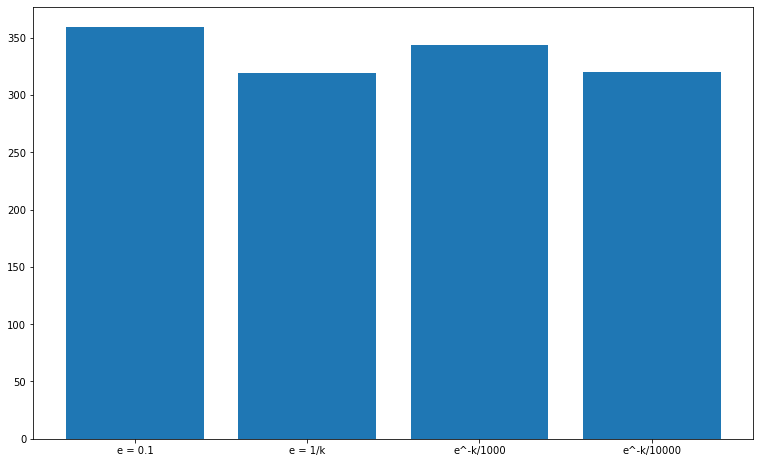

[359, 319, 344, 320]


In [39]:
Q, EA, WA, LA, DA ,SACounterA = Train(False, 1)
Q, EB, WB, LB, DB, SACounterB = Train(False, 2) 
Q, EC, WC, LC, DC, SACounterC = Train(False, 3) 
Q, ED, WD, LD, DD, SACounterD = Train(False, 4) 

allCounters = [SACounterA, SACounterB, SACounterC, SACounterD]
newCounter = list()
for allc in allCounters:
    holdVal = list()
    for k,v in allc.items():
        if v[0] > 10:
            holdVal.append(v[0])
        if v[1] > 10:
            holdVal.append(v[1])
    newCounter.append(len(holdVal))

policy = ["e = 0.1", "e = 1/k", "e^-k/1000", "e^-k/10000"]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])            
       
ax.bar(policy,newCounter)
plt.show()     
print(newCounter)

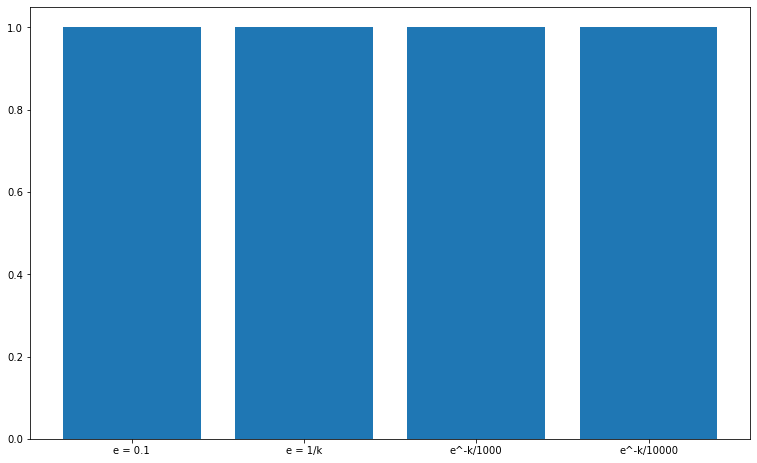

In [40]:
WA = WA[400:500]
WB = WB[400:500]
WC = WC[400:500]
WD = WD[400:500]
LA = LA[400:500]
LB = LB[400:500]
LC = LC[400:500]
LD = LD[400:500]
totalWA = 0
totalWB = 0
totalWC = 0
totalWD = 0
totalLA = 0
totalLB = 0
totalLC = 0
totalLD = 0

for x in range(len(WA)):
    totalWA += WA[x]
    totalWB += WB[x]
    totalWC += WC[x]
    totalWD += WD[x]
    totalLA += LA[x]
    totalLB += LB[x]
    totalLC += LC[x]
    totalLD += LD[x]
    
totalWA /= 100
totalWB /= 100
totalWC /= 100
totalWD /= 100
totalLA /= 100
totalLB /= 100
totalLC /= 100
totalLD /= 100

totalWA = ((totalLA-totalWA)/(totalLA-totalWA))
totalWB = ((totalLB-totalWB)/(totalLB-totalWB))
totalWC = ((totalLC-totalWC)/(totalLC-totalWC))
totalWD = ((totalLD-totalWD)/(totalLD-totalWD))

policy = ["e = 0.1", "e = 1/k", "e^-k/1000", "e^-k/10000"]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])            
    
advantage = [totalWA,totalWB,totalWC,totalWD]

ax.bar(policy,advantage)
plt.show()     

